In [1]:
%%html
<style>
table {
    margin-left: 30pt !important;
    margin-right: auto !important;
    display: block;
}
</style>

<a id='top'></a>

# Code to generate Figure panels related to Figure 5

#### Goldschmidt et al. 2026, "Recent experience and internal state shape local search strategies in flies"
---

<a id='toc'></a>
## Table of Contents

- [Imports](#imports)
- [Figure 5](#figure-5)

| Figure Panel  | Title | Status |
| ------------- | ------------- | :-----------: |
| [Fig. 5B](#fig-5b)  | Illustration of annotated loops  |✅|
| [Fig. 5C](#fig-5c)  | Box- and stripplot of total number of loops per fly |✅|
| [Fig. 5D](#fig-5d)  | Box- and stripplot of distribution of $log_{10}$(loop path length)  |✅|
| [Fig. 5E](#fig-5e)  | Return ratio as a function of the maximum distance to the food reached across genotypes |✅|
| [Fig. 5F](#fig-5f)  | Linear regression of the $log_{10}$(maximal radial loop distance) as a function of the loop number using ordinary least squares |✅|
| [Fig. 5G](#fig-5g)  | Absolute turn bias |✅|
| [Fig. 5H](#fig-5h)  | Run length as function of time since last food  |✅|
| [Fig. 5I](#fig-5i)  | Absolute turn size as function of time since last food  |✅|
| [Fig. 5J](#fig-5j)  | Turn radius as function of time since last food  |✅|

- [Supplemental Figure 5](#figure-s5)

| Figure Panel  | Title | Status |
| ------------- | ------------- | :-----------: |
| [Fig. S5A](#fig-5c)  | Box- and stripplot of mean path length of loop  |✅|
| [Fig. S5B](#fig-5c)  | Box- and stripplot of mean maximum distance from food  |✅|
| [Fig. S5C](#fig-s5c)  | Bimodal distributions of log-transformed, normalized trip lengths for SS96>Kir |✅
| [Fig. S5D](#fig-s5c)  | Bimodal distributions of log-transformed, normalized trip lengths for SS96>TNT |✅|
| [Fig. S5E](#fig-s5c)  | Bimodal distributions of log-transformed, normalized trip lengths for SS90>Kir |✅|
| [Fig. S5F](#fig-s5f)  | Probability of long trips as a function of trip index |✅|
| [Fig. S5G](#fig-s5g)  | Run length distribution |✅|
| [Fig. S5H](#fig-s5h)  | Turn angle distribution |✅|
| [Fig. S5I](#fig-s5i)  | Turn radius distribution |✅|
| [Fig. S5J](#fig-s5j)  | Absolute turn size distribution across genotypes before (left) and after (right) food ||

<a id='imports'></a>
## Imports

In [8]:
from itertools import combinations
import os
import os.path as op
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import io, yaml
from tqdm.auto import tqdm
import platform
import seaborn as sns
from scipy import stats

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
%config Completer.use_jedi = False

pd.options.mode.chained_assignment = None
loopcmap = "gnuplot_r"
timecmap = "crest"

plotDir = op.join('plt', 'paper_src')
os.makedirs(plotDir, exist_ok=True)

from src.helper import rle, read_yaml
from src.interface import combine_yaml
from src.makedataframe import getDataPerGroup, makeLoopDf, makeLoopDepartureStatsDf, addExpInfo, makePerMoveSegmentDF, computeTurnAngBetween2angles
from src.per_trips import get_trip_df, extractGaussianIntersects, fitGMM
from src.viz import seg_label, etho_label, seg_color, etho_color, myAxisTheme, plotArenaAndFood, stripWithBoxplot, stripWithBoxplot_color, pal, cond_color, pval2star
from src.viz import plotGMM, trip_color, trip_color_vs, plot_trip_distribution_fit
from src.viz import condition_palette as pal_con

In [7]:
def makePerMoveSegmentDFNB(df,ethoStatsOfInterest):
    perMoveSegDf = pd.DataFrame()
    for genotype in df.genotype.unique():
        for condition in df.condition.unique():
            for flyid in df.flyid.unique():
                flyDf = df.query(f'flyid=="{flyid}" & condition=="{condition}" & genotype=="{genotype}"')
                if len(flyDf) == 0: continue
                    
                segL, segSt, segType = rle(flyDf.segment)
        
                prev_visit = 0
                cumdist_curr = 0
                cumRunTime_curr = 0                    
                cumtime_curr = 0
        
                moveSegDf_fly = {
                    'time': [],  
                    'seg_state': [],  
                    'etho_state': [],           
                    'after_which_visit': [],
                    'dist_since_visit': [], # total distance travelled during runs since last food spot visit
                    'time_since_visit': [], # time since last food spot visit
                    'cumRunTime_since_visit': [], # total run time since last food spot visit       
                    'seg_duration': [],
                    'seg_length': [], # total distance travelled by fly during this segment
                    'headturnangle': [], # net heading turn angle during movement segment (body angle at end - body angle at start)
                    'absheadturnangle': [], # absolute value of the turn angle
                    'ifCW': [], # whether the turn is in CW direction
                }
        
                for ii, ss in enumerate(segSt):
                    segtype_curr = segType[ii]
                    if segtype_curr == 1:
                        prev_visit = prev_visit + 1
                    if (segtype_curr == 1) or (segtype_curr == 2) or (segtype_curr == 4):
                        cumdist_curr = 0
                        cumRunTime_curr = 0
                        cumtime_curr = 0 # reset time since leaving food spot
        
                    se = min(ss+segL[ii], len(flyDf.body_x.values))
                    
                    ethoL, ethoSt, ethoType, ethoDuration = rle(flyDf.ethogram[ss:se], flyDf.dt[ss:se])
                    moveSegs = np.where(np.isin(ethoType,ethoStatsOfInterest))[0]
                    etho_StartTime = np.cumsum(np.insert(ethoDuration,0,0))
                    moveSegs_starttime = etho_StartTime[moveSegs]
                    moveSegs_ethoType = ethoType[moveSegs]
                        
                    if len(moveSegs) > 0: 
                        for moveIndx in range(len(moveSegs)):
                            moveSegDf_fly['seg_state'].append(segtype_curr)
                            moveSegDf_fly['etho_state'].append(moveSegs_ethoType[moveIndx])
                            moveSegDf_fly['after_which_visit'].append(prev_visit)
        
                            movedur = ethoDuration[moveSegs[moveIndx]]
                            moveSegDf_fly['seg_duration'].append(movedur)
                            
                            moveSegDf_fly['cumRunTime_since_visit'].append(cumRunTime_curr)
                            if segtype_curr != 1: cumRunTime_curr = cumRunTime_curr + movedur
                           
                            moveSegDf_fly['time_since_visit'].append(cumtime_curr + moveSegs_starttime[moveIndx])
                            
                            # segment length (distance)
                            startframe = max(ss + ethoSt[moveSegs[moveIndx]],0)
                            endframe = min(ss + ethoSt[moveSegs[moveIndx]] + ethoL[moveSegs[moveIndx]] + 1, len(flyDf.body_x.values)) # one frame after last frame
                            xpos_all = flyDf.body_x.values[startframe:endframe]
                            ypos_all = flyDf.body_y.values[startframe:endframe]
                            dist_all = np.sqrt((xpos_all[1:]-xpos_all[:-1])**2 + (ypos_all[1:]-ypos_all[:-1])**2)
                            totdist = np.nansum(dist_all)
                            moveSegDf_fly['seg_length'].append(totdist)
                            # store total running distance since last visit
                            moveSegDf_fly['dist_since_visit'].append(cumdist_curr)                        
                            if segtype_curr != 1:
                                cumdist_curr = cumdist_curr + totdist

                            moveSegDf_fly['time'].append(flyDf.time.values[startframe])

                            # starting displacement from center of spot
                            dispVec_fromcenter = np.array([xpos_all[0]-flyDf.food_x.values[0],ypos_all[0]-flyDf.food_y.values[0]])
        
                            # heading angle (vector from body to head of fly):
                            if endframe - startframe > 1:
                                headingAngle_all = flyDf.angle.values[startframe:endframe]
                                headturnangle_all = computeTurnAngBetween2angles(headingAngle_all[0],headingAngle_all[1:])
                                turnAngleDir_all = np.sign(headturnangle_all)
                                changedirFrameInds = np.where(turnAngleDir_all[0:-1] != turnAngleDir_all[1:])[0]
                                numchanges = len(changedirFrameInds)
                                if numchanges == 0:
                                    headturnangle_currseg = headturnangle_all[-1]
                                else:
                                    # investigate the first direction change
                                    changeFrameIndx = changedirFrameInds[-1] # frame right before change in direction
                                    if (np.abs(headturnangle_all[changeFrameIndx]) > np.pi/2) and (np.abs(headturnangle_all[changeFrameIndx+1]) > np.pi/2):
                                        headturnangle_last = headturnangle_all[-1]
                                        headturnangle_currseg = -np.sign(headturnangle_last)*2*np.pi + headturnangle_last
                                    else:
                                        headturnangle_currseg = headturnangle_all[-1]
                                moveSegDf_fly['headturnangle'].append(headturnangle_currseg)
                                moveSegDf_fly['absheadturnangle'].append(np.abs(headturnangle_currseg))
                                ifCW_currseg = headturnangle_currseg<0
                                moveSegDf_fly['ifCW'].append(ifCW_currseg)
                                
                            else:
                                moveSegDf_fly['headturnangle'].append(0)
                                moveSegDf_fly['absheadturnangle'].append(0)
                                moveSegDf_fly['ifCW'].append(np.nan)
        
                    if (segtype_curr == 4) or (segtype_curr == 5) or (segtype_curr == 0):
                        cumtime_curr = cumtime_curr + etho_StartTime[-1]
                        
                moveSegDf_fly = pd.DataFrame(moveSegDf_fly)
                moveSegDf_fly['genotype'] = genotype
                moveSegDf_fly = addExpInfo(moveSegDf_fly, flyid, condition, 'na', 'na', 'na')
                perMoveSegDf = pd.concat([perMoveSegDf, moveSegDf_fly], sort=False)

                # Augment per-segment dataframe with other properties
                # radius of curvature of segments
                perMoveSegDf['effArcRadius'] = perMoveSegDf['seg_length']/perMoveSegDf['absheadturnangle']
                perMoveSegDf['time_min'] = perMoveSegDf.time.values/60
    return perMoveSegDf

# This is a function for automatically getting the names of the parameters of a specified distribution
def list_parameters(distribution):
    """List parameters for scipy.stats.distribution.
    # Arguments
        distribution: a string or scipy.stats distribution object.
    # Returns
        A list of distribution parameter strings.
    """
    if isinstance(distribution, str):
        distribution = getattr(stats, distribution)
    if distribution.shapes:
        parameters = [name.strip() for name in distribution.shapes.split(',')]
    else:
        parameters = []
    if distribution.name in stats._discrete_distns._distn_names:
        parameters += ['loc']
    elif distribution.name in stats._continuous_distns._distn_names:
        parameters += ['loc', 'scale']
    else:
        sys.exit("Distribution name not found in discrete or continuous lists.")
    return parameters

# function for plotting distribution of a quantity of interest across all flies 
# either across conditions or over all conditions
# In this v2, we allow fitting to arbitrary specified distribution, and specify the fitted distribution over the data
def getModelDistributionParams(df, qOI, criteria, fitdist, iflog = False, ifcdf = False):

    # convert fitdist to a distribution object if relevant
    if isinstance(fitdist, str): fitdist = getattr(stats, fitdist)

    # extract parameter names of fitted distribution if relevant
    parameterNames = list_parameters(fitdist)
    numparams = len(parameterNames)

    # include other relevant selection criteria
    for key in criteria.keys():
        minvalue = criteria[key]['min']
        maxvalue = criteria[key]['max']
        df = df.loc[(df[key] >= minvalue) & (df[key] <= maxvalue)]
    
    qoIvec = df[qOI].values
    qoIvec = qoIvec[~np.isnan(qoIvec)]
    if iflog == False: datavec = qoIvec
    elif iflog == True: datavec = np.log10(np.abs(qoIvec[qoIvec!=0]))

    datavec = datavec[~np.isnan(datavec)]
    datavec = datavec[~np.isinf(datavec)]

    try:
        fittedparams = fitdist.fit(datavec)
        xscan = np.linspace(np.min(datavec),np.max(datavec),100) 
        if ifcdf == False: best_fit_line = fitdist.pdf(xscan, *fittedparams)
        else: best_fit_line = fitdist.cdf(xscan, *fittedparams)
    except:
        fittedparams = None
        best_fit_line = None

    return datavec, fittedparams, best_fit_line

def plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol='b',ifcdf = False, iflog = False, ifpdf = True):
    if ifcdf == False: ax.hist(datavec,numbins, density = ifpdf,color = condcol, alpha=0.5)   
    else: ax.hist(datavec,numbins, density = True, histtype = "step", cumulative = True, color = condcol, alpha=0.4)   

    if fittedparams != None:
        xscan = np.linspace(np.min(datavec),np.max(datavec),100) 
        ax.plot(xscan,best_fit_line,linewidth = 1, color = condcol)
        ymax = np.max(best_fit_line)
        
    if iflog == False: qName = qOI
    else: qName = 'log10(' + qOI + ')'
    ax.set_xlabel(qName)
    if ifcdf == False: ax.set_ylabel("P")
    else: ax.set_ylabel("C")

    return ax

In [9]:
rootDir = '/Users/hannahhaberkern/Dropbox/LocalSearchData/data/'
rootDir = '/Users/golddenn/Dropbox/LocalSearchData/data/'
groupName = 'wt-EPGsilencing'

#example fly
flyID = 'fly04'

groups = {
    'wt-EPGsilencing': [
        'JR_SS96xCSMH-TNT_single_dark_5ul_perframe_0-125M_24hr',
        'JR_SS96xCS-Kir_single_dark_5ul_perframe_0-125M_24hr',
        'JR_SS90xCS-Kir_single_dark_5ul_perframe_0-125M_24hr',
        'JR_CantonSMH_single_dark_5ul_perframe_0-125M_24hr'
    ]}

files = groups[groupName]

plotDir = op.join('plt', groupName)
os.makedirs(plotDir, exist_ok=True)

<a id='figure-5'></a>
## Figure 5

### Load all segmented per-frame data

In [10]:
with np.errstate(divide='ignore'):
    datDf, metadata = getDataPerGroup(rootDir, files) 
conditions = list(np.unique(datDf.condition.values))
genotypes = list(np.unique(datDf.genotype.values))
flyids = list(np.unique(datDf.flyid.values))
datDf['isnan'] = np.isnan(datDf.body_x)

for cond in conditions:
    n=len(list(set(datDf.query(f'condition=="{cond}"').fly.values)))
    print(f'{cond}, n={n}')

analyse_per_trip = True

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/makedataframe.py:95: RuntimeWarning: invalid value encountered in divide
  datDf['cff'] = np.divide(datDf.fed.values, datDf.time.values)


0-125M_24hr, n=101


In [11]:
print(conditions)
print(genotypes)
print(flyids)
display(datDf.head())

['0-125M_24hr']
['CantonSMH', 'SS90_x_Kir', 'SS96xCS-Kir', 'SS96xCSMH-TNT']
['fly01', 'fly02', 'fly03', 'fly04', 'fly05', 'fly06', 'fly07', 'fly08', 'fly09', 'fly10', 'fly11', 'fly12', 'fly13', 'fly14', 'fly15', 'fly16', 'fly17', 'fly18', 'fly19', 'fly20', 'fly21', 'fly22', 'fly23', 'fly24', 'fly25', 'fly26', 'fly27', 'fly28', 'fly29', 'fly30', 'fly31']


,fly,condition,genotype,frame,dt,time,body_x,body_y,head_x,head_y,...,arenaRad,food_x,food_y,food_r,distance_patch_0,flyid,is_feeding,fed,cff,isnan
0,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,0,0.041694,0.000000,-42.350709,-3.112243,-43.512858,-2.224283,...,83.411317,-0.045568,-0.068352,1.449057,42.414505,fly01,0,0.0,0.0,False
1,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,1,0.041694,0.041694,-42.350709,-3.112243,-43.512858,-2.224283,...,83.411317,-0.045568,-0.068352,1.449057,42.414505,fly01,0,0.0,0.0,False
2,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,2,0.041694,0.083388,-42.350709,-3.112243,-43.512858,-2.224283,...,83.411317,-0.045568,-0.068352,1.449057,42.414505,fly01,0,0.0,0.0,False
3,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,3,0.041693,0.125081,-42.159541,-3.121224,-43.163510,-2.024842,...,83.411317,-0.045568,-0.068352,1.449057,42.224481,fly01,0,0.0,0.0,False
4,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,4,0.041694,0.166775,-42.014811,-2.974062,-42.677084,-1.639968,...,83.411317,-0.045568,-0.068352,1.449057,42.069711,fly01,0,0.0,0.0,False


In [34]:
allData_df = pd.concat([pd.read_feather(rootDir + f+'.feather') for f in files], ignore_index=True)
genotypes = list(allData_df.genotype.unique())[::-1]
conditions = list(allData_df.condition.unique())
all_metadata = combine_yaml([rootDir + f+'.yaml' for f in files])

print(conditions)
print(genotypes)
print(allData_df.columns)
display(allData_df.head())

['0-125M_24hr']
['CantonSMH', 'SS90_x_Kir', 'SS96xCS-Kir', 'SS96xCSMH-TNT']
Index(['fly', 'condition', 'genotype', 'frame', 'dt', 'time', 'body_x',
       'body_y', 'head_x', 'head_y', 'angle', 'major', 'minor', 'body_speed',
       'head_speed', 'angular_speed', 'curvature', 'ethogram', 'segment'],
      dtype='object')


,fly,condition,genotype,frame,dt,time,body_x,body_y,head_x,head_y,angle,major,minor,body_speed,head_speed,angular_speed,curvature,ethogram,segment
0,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,0,0.041694,0.000000,-42.350709,-3.112243,-43.512858,-2.224283,2.489149,2.925107,1.233443,0.191575,0.338810,-0.146328,-0.012834,4.0,5.0
1,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,1,0.041694,0.041694,-42.350709,-3.112243,-43.512858,-2.224283,2.489149,2.925107,1.233443,-0.766302,-1.355238,0.585312,-0.012834,1.0,5.0
2,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,2,0.041694,0.083388,-42.350709,-3.112243,-43.512858,-2.224283,2.489149,2.925107,1.233443,1.149453,2.032857,-0.877968,-0.012834,1.0,5.0
3,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,3,0.041693,0.125081,-42.159541,-3.121224,-43.163510,-2.024842,2.312224,2.973220,1.220847,3.495737,8.622416,-3.826923,0.011223,1.0,5.0
4,bias_video_cam_0_date_2019_06_20_time_11_24_06...,0-125M_24hr,SS96xCSMH-TNT,4,0.041694,0.166775,-42.014811,-2.974062,-42.677084,-1.639968,2.031577,2.978867,1.225976,5.566871,14.667288,-6.630407,0.030863,2.0,5.0


## Create per-move segment dataframe

In [17]:
slct_ethoStates = [1,2] #{0: 'border', 1: 'turn', 2: 'run', 3: 'feeding', 4: 'other'}
slct_cond = list(datDf.condition.unique())
datDf_filt = datDf.query(f'ethogram != {4} & condition in {slct_cond}')

# create per-move segment dataframe consisting only of runs and turns
perMoveSegDF = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    perMoveSegDF_tmp = makePerMoveSegmentDFNB(datDf_filt.query(f'genotype=="{genotype}"'),ethoStatsOfInterest=slct_ethoStates)
    perMoveSegDF_tmp['genotype'] = genotype
    perMoveSegDF = pd.concat([perMoveSegDF, perMoveSegDF_tmp])

## Generate Trip Dataframe

In [21]:
per_trip_df = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    per_trip_df_tmp = get_trip_df(allData_df.query(f'genotype=="{genotype}"'), all_metadata)
    per_trip_df_tmp['genotype'] = genotype
    per_trip_df = pd.concat([per_trip_df,per_trip_df_tmp])
per_trip_df.head()

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)


  0%|          | 0/28 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)


,fly,flyid,condition,trip_index,time,cumul_feeding,norm_cumul_feeding,duration,length,runturnsegs,previsit_duration,isloop,postvisit_duration,scaled_duration,scaled_length,scaled_duration_loop,scaled_length_loop,scaled_previsit_duration,scaled_postvisit_duration,genotype
0,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,0-125M_24hr,0.0,903.170895,44.695753,0.675063,0.833876,1.846839,2.0,903.170895,1.0,2.376546,0.002781,0.001407,0.326531,0.302103,4.861747,0.370130,SS96xCSMH-TNT
1,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,0-125M_24hr,1.0,906.381317,45.863180,0.692695,6.754396,19.382924,11.0,2.376546,1.0,12.758302,0.022523,0.014766,2.644898,3.170628,0.012793,1.987013,SS96xCSMH-TNT
2,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,0-125M_24hr,2.0,925.894015,57.537443,0.869018,1.334202,2.293017,1.0,12.758302,1.0,4.044298,0.004449,0.001747,0.522449,0.375088,0.068678,0.629870,SS96xCSMH-TNT
3,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,0-125M_24hr,3.0,931.272515,61.164803,0.923804,1.292508,0.930326,1.0,4.044298,1.0,6.504233,0.004310,0.000709,0.506122,0.152181,0.021770,1.012987,SS96xCSMH-TNT
4,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,0-125M_24hr,4.0,939.069256,66.042976,0.997481,1489.260868,6539.064143,1099.0,6.504233,0.0,NaN,4.965938,4.981372,583.167300,1069.649699,0.035012,NaN,SS96xCSMH-TNT


## Merge "per-move segment" and "per-trip" dataframes (restricted to "post food phase)

In [22]:
per_move_postfood_df = pd.DataFrame()
# loop over genotypes, conditions, flies and add trip information (this could be done more elegantly)
for genotype in genotypes:
    for condition in conditions:
        for flyid in perMoveSegDF.fly.unique():

            # generate a copy of the per-move segment dataframe that only contains data after the first food visit
            flyDf_move = perMoveSegDF.query(f'fly=="{flyid}" & condition=="{condition}" & genotype=="{genotype}" & after_which_visit >0').reset_index(drop=True)
            if len(flyDf_move) == 0: continue
            
            flyDf_move['flyid'] = flyDf_move.fly.values

            if analyse_per_trip:
                flyDf_trip = per_trip_df.query(f'flyid=="{flyid}" & condition=="{condition}" & genotype=="{genotype}"').reset_index(drop=True)
                flyDf_trip['after_which_visit'] = flyDf_trip.trip_index.values.astype('int') + 1
                df = pd.merge(flyDf_move, flyDf_trip, on=['genotype','condition', 'flyid','after_which_visit'], how='outer')
            else:
                df = flyDf_move
            per_move_postfood_df = pd.concat([per_move_postfood_df, df], sort=False)

## Classify trips into long vs short based on extracted thresholds

In [23]:
qOIs = ['duration','scaled_duration','scaled_duration_loop','length', 'scaled_length','scaled_length_loop']
qSlct = 4
condsOI = conditions

segThr = 5

fit_type = 'GMM'
fitparams = {  
    "Nmin": 2,
    "Nmax": 2,
}

triptype_df = pd.DataFrame({'genotype':[], 'flyid':[],'condition':[], 'trip_index':[], 'duration':[],'scaled_duration':[], 'length':[], 'scaled_length':[],'scaled_length_loop':[]})
log10qthresMat = np.zeros((len(condsOI),len(qOIs)))


for g, genotype in enumerate(genotypes):
    for c, condOI in enumerate(condsOI):
        for q, qOI in enumerate(qOIs):
            qVec = per_trip_df.query(f'condition == "{condOI}" & genotype=="{genotype}"')[qOI].values
            if q==qSlct: print(qOI)
            if len(qVec) == 0: continue
            qVec = qVec[~np.isnan(qVec)]
            data_curr = np.log10(qVec[qVec>0])
            data_curr = data_curr.reshape(-1,1)
            
            xthres = extractGaussianIntersects(data_curr)
            log10qthresMat[c,q] = xthres[0]
    
        mydf = per_trip_df.query(f'condition == "{condOI}" & genotype=="{genotype}"')[['flyid','condition','trip_index', 'duration','scaled_duration','length','scaled_length','scaled_length_loop', 'runturnsegs']]
        trip_threshold = 10**log10qthresMat[c,qSlct]
        triptype = np.where(mydf[qOIs[qSlct]].values <= trip_threshold, 'short', 'long') 
    
        tripseglen = mydf.runturnsegs.values
        triptype2 = ['very short' if (tripseglen[i] <= segThr and triptype[i]=='short') else triptype[i] for i in range(len(triptype))]
        
        mydf['genotype'] = genotype
        mydf['triptype'] = triptype
        mydf['triptype_vs'] = triptype2
        triptype_df = pd.concat((triptype_df,mydf))
    
print(log10qthresMat)
per_trip_df = pd.merge(per_trip_df, triptype_df, on=['genotype','flyid','condition', 'trip_index','duration','scaled_duration','length','scaled_length' ,'scaled_length_loop', 'runturnsegs'])
display(per_trip_df.columns)

### Saving DF
per_trip_df['log10_duration'] = np.log10(per_trip_df.duration.values)
per_trip_df['log10_scaled_duration'] = np.log10(per_trip_df.scaled_duration.values)
per_trip_df['log10_length'] = np.log10(per_trip_df.length.values)
per_trip_df['log10_scaled_length'] = np.log10(per_trip_df.scaled_length_loop.values)

per_trip_df.to_csv(getcwd() + sep + 'plt'+sep+groupName+sep+'tripDf_'+groupName+'.csv')
per_trip_df[['genotype','flyid','condition','trip_index','duration','scaled_duration','length','scaled_length','scaled_length_loop','scaled_duration_loop', 'triptype', 'triptype_vs']].tail()

scaled_length
scaled_length
scaled_length
scaled_length
[[ 1.15972897 -0.43911657  0.22117668  1.34112808 -0.79544007 -0.08222487]]


Index(['fly', 'flyid', 'condition', 'trip_index', 'time', 'cumul_feeding',
       'norm_cumul_feeding', 'duration', 'length', 'runturnsegs',
       'previsit_duration', 'isloop', 'postvisit_duration', 'scaled_duration',
       'scaled_length', 'scaled_duration_loop', 'scaled_length_loop',
       'scaled_previsit_duration', 'scaled_postvisit_duration', 'genotype',
       'triptype', 'triptype_vs'],
      dtype='object')

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_51793/4206113923.py:49: RuntimeWarning: divide by zero encountered in log10
  per_trip_df['log10_length'] = np.log10(per_trip_df.length.values)
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_51793/4206113923.py:50: RuntimeWarning: divide by zero encountered in log10
  per_trip_df['log10_scaled_length'] = np.log10(per_trip_df.scaled_length_loop.values)


,genotype,flyid,condition,trip_index,duration,scaled_duration,length,scaled_length,scaled_length_loop,scaled_duration_loop,triptype,triptype_vs
2654,CantonSMH,fly28,0-125M_24hr,15.0,9.256020,0.195845,4.699934,0.075068,0.346292,0.263707,short,very short
2655,CantonSMH,fly28,0-125M_24hr,16.0,6.254069,0.132328,1.179102,0.018833,0.086876,0.178181,short,very short
2656,CantonSMH,fly28,0-125M_24hr,17.0,0.792182,0.016762,0.430184,0.006871,0.031696,0.022570,short,very short
2657,CantonSMH,fly28,0-125M_24hr,18.0,21.889237,0.463147,8.492122,0.135637,0.625701,0.623632,short,very short
2658,CantonSMH,fly28,0-125M_24hr,19.0,4.961561,0.104980,2.260343,0.036102,0.166542,0.141357,short,very short


## Compute loop (and departure) statistics

In [24]:
numFeedBins = 10
myDistBins = [0,3,6,9,12,15,20,30,40,50,60]
myDistBins_even = list(np.arange(0,61,4))
myDistBins_farClose = [0,20,60]
loopBins = list(np.arange(1,52,4))
loopBinsShort = list(np.arange(1,32,3))
cffBins = np.linspace(-0.1,1,12)

loopDf = pd.DataFrame()
loopDepDf = pd.DataFrame()
with np.errstate(divide='ignore'):
    for g, genotype in enumerate(genotypes):
        print(genotype)
        loopDf_tmp, loopDepDf_tmp = makeLoopDf(datDf.query(f'genotype=="{genotype}"'))
        loopDf_tmp['genotype'] = genotype
        loopDf = pd.concat([loopDf,loopDf_tmp])
        loopDepDf_tmp['genotype'] = genotype
        loopDepDf = pd.concat([loopDepDf,loopDepDf_tmp])
loopDf['feedingBin'] = pd.cut(loopDf["normFed"],numFeedBins)

loopLenStats2 = pd.DataFrame(loopDf.groupby(['genotype','condition','flyid','loopN']).min()[['loop_time']].to_records())
loopLenStats = pd.DataFrame(loopDf.groupby(['genotype','condition','flyid','loopN']).max()[['loop_length','distance_patch_0','fed','normFed', 'deltaCFF']].to_records())
loopLenStats['pathLengthDistanceRatio'] = loopLenStats.loop_length/loopLenStats.distance_patch_0
loopLenStats['maxDistBin_uneven'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins, precision=1, right=False)
loopLenStats['maxDistBin'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins_even, precision=1, right=False)
loopLenStats['maxDistBin_farclose'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins_farClose, precision=1, right=False)
loopLenStats['deltaCFFBin'] = pd.cut(loopLenStats["deltaCFF"],bins=cffBins, precision=3,right=False)
loopLenStats['loopN_bin'] = pd.cut(loopLenStats["loopN"],bins=loopBins, precision=1,right=False)
loopLenStats['loopN_binShort'] = pd.cut(loopLenStats["loopN"],bins=loopBinsShort, precision=1,right=False)
loopLenStats['loopN_binShort_num'] = pd.cut(loopLenStats["loopN"],bins=loopBinsShort, precision=1, labels=False,right=False)

loopLenStats['loop_time'] = loopLenStats2.loop_time.values
display(loopLenStats.head())

SS96xCSMH-TNT
SS96xCS-Kir
SS90_x_Kir
CantonSMH


,genotype,condition,flyid,loopN,loop_length,distance_patch_0,fed,normFed,deltaCFF,pathLengthDistanceRatio,maxDistBin_uneven,maxDistBin,maxDistBin_farclose,deltaCFFBin,loopN_bin,loopN_binShort,loopN_binShort_num,loop_time
0,CantonSMH,0-125M_24hr,fly01,1,8.433359,2.493245,457.383180,0.460,0.927225,3.382483,"[0, 3)","[0, 4)","[0, 20)","[0.9, 1.0)","[1, 5)","[1, 4)",0.0,0.000000
1,CantonSMH,0-125M_24hr,fly01,2,18.983103,5.287020,624.451038,0.629,0.012637,3.590511,"[3, 6)","[4, 8)","[0, 20)","[0.0, 0.1)","[1, 5)","[1, 4)",0.0,172.195390
2,CantonSMH,0-125M_24hr,fly01,3,8.775373,4.707908,628.620438,0.633,-0.000198,1.863964,"[3, 6)","[4, 8)","[0, 20)","[-0.1, 0.0)","[1, 5)","[1, 4)",0.0,179.867049
3,CantonSMH,0-125M_24hr,fly01,4,29.348879,7.340134,640.544922,0.645,-0.000299,3.998412,"[6, 9)","[4, 8)","[0, 20)","[-0.1, 0.0)","[1, 5)","[4, 7)",1.0,194.334798
4,CantonSMH,0-125M_24hr,fly01,5,6.129625,2.923535,653.303286,0.658,0.000195,2.096648,"[0, 3)","[0, 4)","[0, 20)","[0.0, 0.1)","[5, 9)","[4, 7)",1.0,212.763458


#### Statistics on both loops and departures

In [25]:
loopdepStats = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    print(genotype)
    loopdepStats_tmp = makeLoopDepartureStatsDf(datDf.query(f'genotype=="{genotype}"'))
    loopdepStats_tmp['genotype'] = genotype
    loopdepStats = pd.concat([loopdepStats,loopdepStats_tmp])

loopdepStats['feedingBin'] = pd.cut(loopdepStats["normFed"],numFeedBins, precision=0,right=False)
loopdepStats['maxDistBin'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins_even, precision=1,right=False)
loopdepStats['maxDistBin_uneven'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins, precision=1,right=False)
loopdepStats['maxDistBin_farClose'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins_farClose, precision=1,right=False)
display(loopdepStats.head())

distDf = pd.DataFrame(columns = ['condition','flyid','maxDistRange','loopCount','returnratio'])
for genotype in genotypes:
    conddf = loopdepStats.query(f'genotype == "{genotype}"')
    flies = list(conddf.flyid.unique())
    for fly in flies:
        for r in myDistBins[1:]: #[1:]
            flydf = conddf.query(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            #print(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            if len(flydf) == 0:
                tmp = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'loopCount':[0]})
            else:
                tmp = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']].rename(columns={'maxDist':'loopCount'})
            tmp['maxDistRange'] = r
            
            flydf = conddf.query('segment == 4 & maxDist >= {} & flyid =="{}"'.format(r, fly))
            if len(flydf) == 0:
                tmp2 = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'nDepartures':[0]})
            else:
                tmp2 = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']]
            tmp = (pd.merge(tmp, tmp2, on=['genotype','flyid'])).rename(columns={'maxDist':'nDepartures'})
            tmp['allsegs'] = tmp.nDepartures + tmp.loopCount
            tmp = tmp[(tmp.allsegs > 0)]
            tmp['returnratio'] = tmp.loopCount.values/(tmp.loopCount.values + tmp.nDepartures.values)
            distDf = pd.concat([distDf,tmp])

distDf_farClose = pd.DataFrame(columns = ['condition','flyid','maxDistRange','loopCount','returnratio'])
for genotype in genotypes:
    conddf = loopdepStats.query(f'genotype == "{genotype}"')
    flies = list(conddf.flyid.unique())
    for fly in flies:
        for r in myDistBins_farClose[:-1]: #returns for everything >0 and everything > 20
            flydf = conddf.query(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            if len(flydf) == 0:
                tmp = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'loopCount':[0]})
            else:
                tmp = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']].rename(columns={'maxDist':'loopCount'})
            tmp['maxDistRange'] = r
            
            flydf = conddf.query('segment == 4 & maxDist >= {} & flyid =="{}"'.format(r, fly))
            if len(flydf) == 0:
                tmp2 = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'nDepartures':[0]})
            else:
                tmp2 = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']]
            tmp = (pd.merge(tmp, tmp2, on=['genotype','flyid'])).rename(columns={'maxDist':'nDepartures'})
            tmp['allsegs'] = tmp.nDepartures + tmp.loopCount
            tmp = tmp[(tmp.allsegs > 0)]
            tmp['returnratio'] = tmp.loopCount.values/(tmp.loopCount.values + tmp.nDepartures.values)
            distDf_farClose = pd.concat([distDf_farClose,tmp])

SS96xCSMH-TNT
SS96xCS-Kir
SS90_x_Kir
CantonSMH


,condition,fly,flyid,segment,ethogram,distance_patch_0,displacement,dt,is_feeding,fed,...,segID,cumpathlength,maxDist,pathLength,pathLengthDistanceRatio,genotype,feedingBin,maxDistBin,maxDistBin_uneven,maxDistBin_farClose
0,0-125M_24hr,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,2.0,1.0,1.419826,0.385696,0.041694,0,44.695753,...,1,0.385696,3.560763,5.517970,1.549659,SS96xCSMH-TNT,"[0.6, 0.7)","[0.0, 4.0)","[3.0, 6.0)","[0.0, 20.0)"
1,0-125M_24hr,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,2.0,1.0,1.336732,0.294874,0.041694,0,45.863180,...,2,0.294874,11.602438,48.130771,4.148333,SS96xCSMH-TNT,"[0.6, 0.7)","[8.0, 12.0)","[9.0, 12.0)","[0.0, 20.0)"
2,0-125M_24hr,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,2.0,1.0,0.749995,0.305124,0.041694,0,57.537443,...,3,0.305124,4.253572,8.114840,1.907771,SS96xCSMH-TNT,"[0.8, 0.9)","[4.0, 8.0)","[3.0, 6.0)","[0.0, 20.0)"
3,0-125M_24hr,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,2.0,2.0,1.860944,0.306295,0.041694,0,61.164803,...,4,0.306295,3.779576,5.060598,1.338933,SS96xCSMH-TNT,"[0.9, 1.0)","[0.0, 4.0)","[3.0, 6.0)","[0.0, 20.0)"
4,0-125M_24hr,bias_video_cam_0_date_2019_06_20_time_11_24_06...,fly01,4.0,1.0,0.710993,0.165098,0.041693,0,66.042976,...,5,0.165098,74.274936,123.854091,1.667509,SS96xCSMH-TNT,"[0.9, 1.0)",NaN,NaN,NaN


/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_51793/588096699.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distDf = pd.concat([distDf,tmp])
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_51793/588096699.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distDf_farClose = pd.concat([distDf_farClose,tmp])


<a id='fig-5b'></a>
## Fig. 5B - Illustration of annotated loops

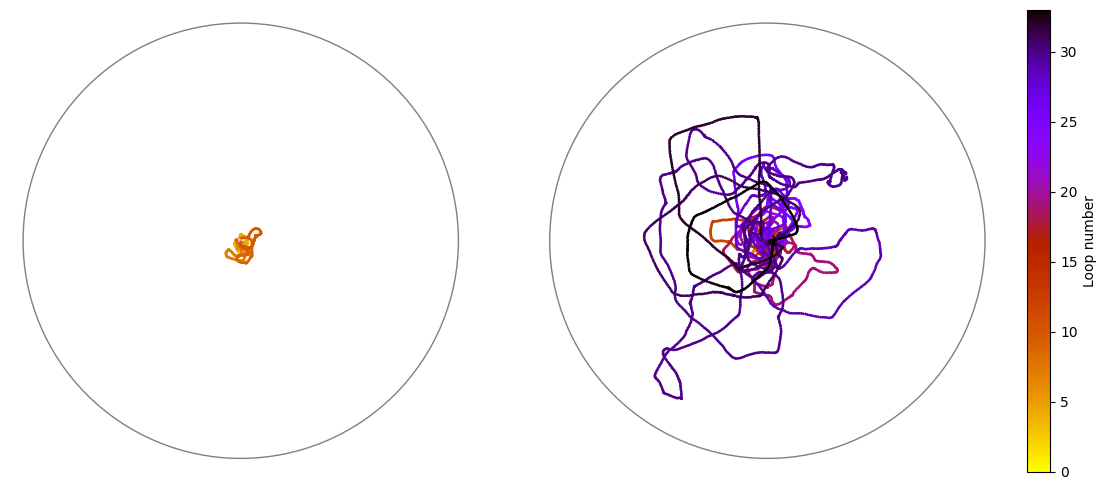

In [29]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
example_genotype = 'SS96xCSMH-TNT'
plotDf = loopDf.query(f'genotype=="{example_genotype}" & flyid=="{flyID}"')
n = plotDf.loopN.unique()[-1]
N = 10
axs[0].scatter(plotDf.query('loopN <= {}'.format(N)).body_x.values, plotDf.query('loopN <= {}'.format(N)).body_y.values,s=1,
               c=plotDf.query('loopN <= {}'.format(N)).loopN.values,cmap=loopcmap, vmin=0, vmax=n) 
plotArenaAndFood(axs[0], foodRad=plotDf.food_r.values[0], arenaRad=plotDf.arenaRad.values[0],foodCol='firebrick')

cb = axs[1].scatter(plotDf.body_x.values,plotDf.body_y.values,s=1,c=plotDf.loopN.values,cmap=loopcmap,vmin=0, vmax=n) 
plotArenaAndFood(axs[1], foodRad=plotDf.food_r.values[0], arenaRad=plotDf.arenaRad.values[0],foodCol='firebrick')
plt.colorbar(cb,label='Loop number')
fig.tight_layout()
fig.savefig(plotDir+sep+f'loopIllustration_{flyID}_Fig5B.pdf')

<a id='fig-5c'></a>
## Fig. 5C, S5A, S5B - Box- and stripplot of (5C) total number of loops per fly, (S5A) mean path length of loop, and (S5B) mean maximum distance from food

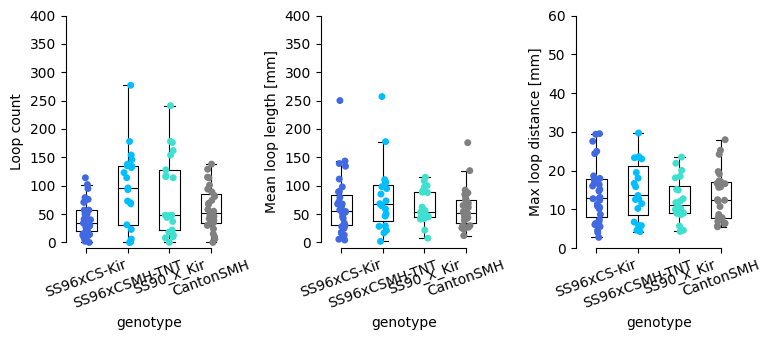

In [31]:
genorder= ['SS96xCS-Kir', 'SS96xCSMH-TNT', 'SS90_x_Kir', 'CantonSMH']

absLoopCount = distDf.groupby(['genotype','flyid'])[['loopCount']].sum().reset_index()
myfigsize=(.65*len(genotypes)*3,3.5)
fig, axs = plt.subplots(1,3,figsize=myfigsize)

sns.stripplot(x='genotype', y='loopCount', hue='genotype',palette=pal,data=absLoopCount,dodge=False, ax=axs[0], order=genorder)
sns.boxplot(data=absLoopCount, x='genotype', y='loopCount', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[0], order=genorder)
plt.setp(axs[0].lines, color='k',linewidth=0.8)
axs[0].set_ylim(-10,400)
axs[0].set_ylabel('Loop count')

meanLoopLen = pd.DataFrame(loopLenStats.groupby(['genotype','flyid']).mean('loop_length')['loop_length']).reset_index()

sns.stripplot(x='genotype', y='loop_length', hue='genotype',palette=pal,data=meanLoopLen,dodge=False,ax=axs[1], order=genorder)
sns.boxplot(data=meanLoopLen, x='genotype', y='loop_length', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[1], order=genorder)
plt.setp(axs[1].lines, color='k',linewidth=0.8)
axs[1].set_ylim(-10,400)
axs[1].set_ylabel('Mean loop length [mm]')

meanLoopLen = pd.DataFrame(loopLenStats.groupby(['genotype','condition', 'flyid']).mean('distance_patch_0')['distance_patch_0']).reset_index()

sns.stripplot(x='genotype', y='distance_patch_0', hue='genotype',palette=pal,data=meanLoopLen,dodge=False,ax=axs[2], order=genorder)
sns.boxplot(data=meanLoopLen, x='genotype', y='distance_patch_0', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[2], order=genorder)
plt.setp(axs[2].lines, color='k',linewidth=0.8)
axs[2].set_ylim(0,60)
axs[2].set_ylabel('Max loop distance [mm]')

for ax in axs:
    ax.set_xticks(range(len(genotypes)))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);

sns.despine(trim=True)
fig.tight_layout()
fig.savefig(plotDir+sep+'loopStats_genotypeComparison_Fig5C-FigS5AB.pdf')

<a id='fig-5d'></a>
## Fig. 5D - Box- and stripplot of distribution of $log_{10}$(loop path length)

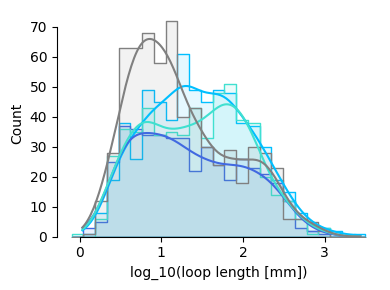

In [32]:
tmp = loopLenStats[['condition','genotype','flyid','loopN','loop_length']]
tmp['log_loop_length'] = np.log10(tmp['loop_length'])

fig, axs = plt.subplots(1,1,figsize=(4,3))
sns.histplot(ax=axs, data=tmp, x='log_loop_length', hue='genotype', bins=25, binrange=(-.1,3.5), element="step", fill=True, alpha=0.1,
             palette=pal,kde=True, legend=False)
axs.set_xlabel('log_10(loop length [mm])')
sns.despine(trim=True)
fig.tight_layout()
fig.savefig(plotDir+sep+'loopStats_loopLenDistribution_Fig5D.pdf')

<a id='fig-5e'></a>
## Fig. 5E - Return ratio as a function of the maximum distance to the food reached across genotypes

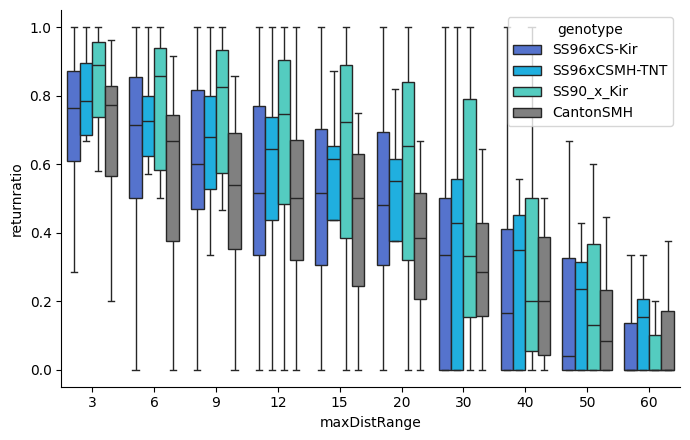

In [36]:
fig, axs = plt.subplots(1,1,figsize=(1+1.5*len(genotypes),4.5))
sns.boxplot(x='maxDistRange', y='returnratio', hue='genotype', data=distDf, showfliers = False, ax=axs, palette=pal, hue_order=genorder)
myAxisTheme(axs)
fig.tight_layout()
fig.savefig(plotDir+sep+'loopAndDepartureStatsVsCumDist_simpleGroupComparison_Fig5E.pdf')

<a id='fig-5f'></a>
## Fig. 5F - Linear regression of the $log_{10}$(maximal radial loop distance) as a function of the loop number using ordinary least squares

CantonSMH
n=24
                            OLS Regression Results                            
Dep. Variable:               log_dist   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     49.54
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           6.27e-12
Time:                        11:16:49   Log-Likelihood:                -254.63
No. Observations:                 514   AIC:                             513.3
Df Residuals:                     512   BIC:                             521.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6145      0.035     

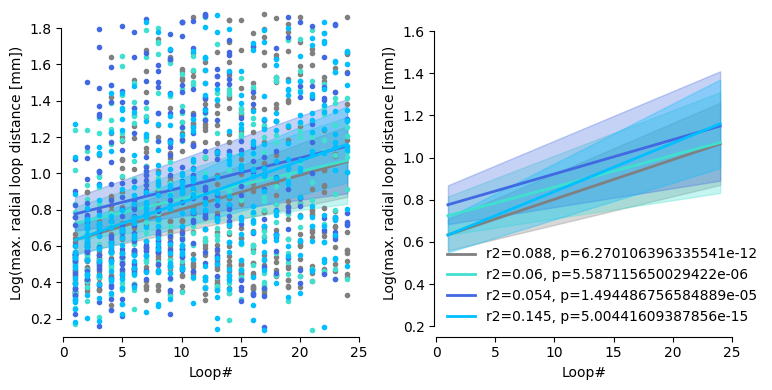

In [35]:
import statsmodels.formula.api as smf
fig, axs = plt.subplots(1,2, figsize=(8,4))    

for g, genotype in enumerate(genotypes):
    print(genotype)
    statsDf = loopLenStats.query(f'genotype == "{genotype}" & loopN < 25')[['flyid','loopN','distance_patch_0']]
    statsDf['log_dist'] = np.log10(statsDf.distance_patch_0)
    cts = statsDf.groupby('flyid').count().reset_index()
    slctflies = list(cts.query('loopN >= 10').flyid.values)
    print(f'n={len(slctflies)}')
    statsDf = statsDf.query(f'flyid in {slctflies}')

    axs[0].plot(statsDf.loopN, statsDf.log_dist,'.',color=pal[genotype])
    model = smf.ols(formula='log_dist~loopN', data=statsDf).fit()
    p = model.params
    x = np.arange(1, 25)   
    civ = model.conf_int(alpha=0.05)
    # plot regression line on the same axes, set x-axis limits
    axs[0].plot(x, p.Intercept + p.loopN*x,linewidth=2, color=pal[genotype], label=f'r2={round(model.rsquared,3)}, p={model.pvalues.loopN}')
    axs[0].fill_between(x, civ[0].Intercept + civ[0].loopN*x, civ[1].Intercept + civ[1].loopN*x,alpha=0.3,color=pal[genotype], label='')

    axs[1].plot(x, p.Intercept + p.loopN*x,linewidth=2, color=pal[genotype], label=f'r2={round(model.rsquared,3)}, p={model.pvalues.loopN}')
    axs[1].fill_between(x, civ[0].Intercept + civ[0].loopN*x, civ[1].Intercept + civ[1].loopN*x,alpha=0.3,color=pal[genotype], label='')

    print(model.summary())
    print('\n')
    
axs[0].set_ylim(0.1,1.9)
axs[1].set_ylim(0.15,1.7)
axs[1].legend(frameon=False)
for ax in axs:
    ax.set_xlabel('Loop#')
    ax.set_ylabel('Log(max. radial loop distance [mm])')
    sns.despine(trim=True, ax=ax)
fig.tight_layout()
fig.savefig(plotDir+sep+'loopscaling_groupComparison_linearReg_Fig5F.pdf')

## Save preprocessed data to file

In [19]:
distDf.to_csv(plotDir+sep+'distDf_{}.csv'.format(groupName))
distDf_farClose.to_csv(plotDir+sep+'distDf_farClose_{}.csv'.format(groupName))
loopdepStats.to_csv(plotDir+sep+'loopStats_{}.csv'.format(groupName))
loopLenStats.to_csv(plotDir+sep+'loopLenStats_{}.csv'.format(groupName))

<a id='fig-5g'></a>
## Fig. 5G - Absolute turn bias

CantonSMH
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "CantonSMH" & after_which_visit ==0& condition == "0-125M_24hr"
SS90_x_Kir
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "SS90_x_Kir" & after_which_visit ==0& condition == "0-125M_24hr"
SS96xCS-Kir
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "SS96xCS-Kir" & after_which_visit ==0& condition == "0-125M_24hr"
SS96xCSMH-TNT
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "SS96xCSMH-TNT" & after_which_visit ==0& condition == "0-125M_24hr"
CantonSMH
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "CantonSMH" & after_which_visit >=1& condition == "0-125M_24hr"
SS90_x_Kir
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "SS90_x_Kir" & after_which_visit >=1& condition == "0-125M_24hr"
SS96xCS-Kir
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "SS96xCS-Kir" & after_which_visit >=1& condition == "0-125M_24hr"
SS96xCSMH-TNT
seg_state in [2, 3, 4, 5] & 

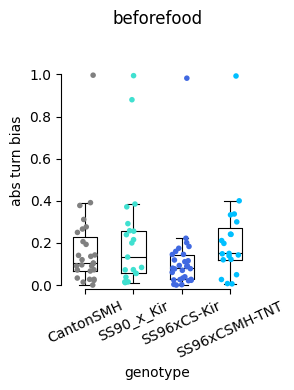

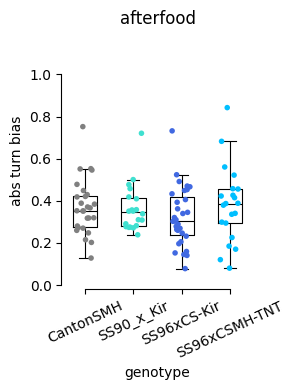

In [37]:
etho_state = [1] # turns

for i, visitTH in enumerate(['==0','>=1']): #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'

    #itterate through genotypes to fetch correct data
    means_tmp = pd.DataFrame()
    counts_tmp = pd.DataFrame()
    for g, genotype in enumerate(genotypes):
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'
        if len(genotypes) > 1 :
            querystring = querystring + f'& condition == "{conditions[0]}"'
        print(genotype)
        print(querystring)
        means_tmp = pd.concat([means_tmp,perMoveSegDF.query(querystring)])
        counts_tmp = pd.concat([counts_tmp,perMoveSegDF.query(querystring)])
    
    keep_indices = ['genotype','condition','fly','after_which_visit']
    means = means_tmp.groupby(keep_indices)['ifCW'].mean().reset_index()
    counts = counts_tmp.groupby(keep_indices)['ifCW'].count().reset_index()
    perMoveSegDF_filt = pd.merge(means,counts,on=keep_indices)
    perMoveSegDF_filt = perMoveSegDF_filt.rename(columns={"ifCW_x": "ifCW", "ifCW_y": "turnCount"})
    #rescale turn bias
    perMoveSegDF_filt['ifCWplt'] = 2*(perMoveSegDF_filt.ifCW.values-0.5)
    perMoveSegDF_filt = perMoveSegDF_filt.query('turnCount >= 3')

    plotdf = perMoveSegDF_filt.copy()
    plotdf['abs_ifCW'] = np.abs(plotdf.ifCW.values -0.5)*2
    tmp = plotdf.groupby(['genotype','fly'])['abs_ifCW'].mean().reset_index()
    absTurnBiasMedians = tmp.groupby(['genotype'])[['abs_ifCW']].median().reset_index()
    plotdf.to_csv(plotDir+sep+'absturnBias_'+postfix+'.csv', index=False)  

    fig, axs = plt.subplots(1,1,figsize=(3,4))
    tmp = plotdf.groupby(['genotype','fly'])['abs_ifCW'].mean().reset_index()
    sns.stripplot(tmp, x='genotype', y='abs_ifCW', hue='genotype', palette=pal, ax=axs, size=4, jitter=.2)
    sns.boxplot(tmp, x='genotype', y='abs_ifCW', dodge=False, legend=False,fill=False, fliersize=0, width=0.5)
    axs.set_xticks(range(len(plotdf['genotype'].unique()))) 
    plt.setp(axs.lines, color='k',linewidth=0.8)
    axs.set_xticklabels(axs.get_xticklabels(),rotation = 25);
    axs.set_ylabel('abs turn bias')
    axs.set_ylim(-0.02,1.2)
    sns.despine(trim=True)
    axs.legend('',frameon=False)
    axs.set_title(postfix)
    fig.tight_layout()
    #fig.savefig(plotDir+sep+'absturnBias_perfly_'+postfix+'.pdf')

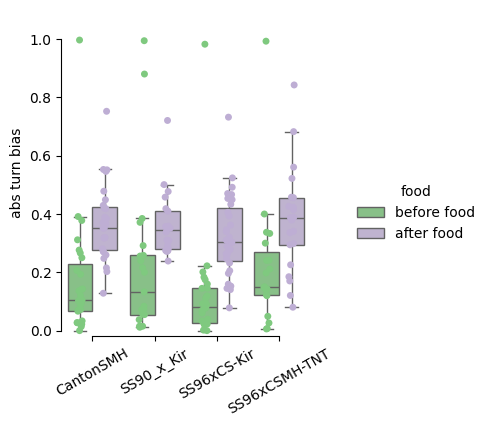

In [38]:
# compare turn bias before and after food
try: plotdf_pre = pd.read_csv(plotDir+sep+'absturnBias_beforefood.csv')
except: print('precalculate turn bias for before and after food encounter')
try: plotdf_post = pd.read_csv(plotDir+sep+'absturnBias_afterfood.csv')
except: print('precalculate turn bias for before and after food encounter')

plotdf_pre['food'] = 'before food'
plotdf_post['food'] = 'after food'
plotdf_all = pd.concat([plotdf_pre, plotdf_post])

plotdf_all.to_csv(plotDir+sep+'absturnBias_panel_forStatistic.csv', index=False)  
plotdf = plotdf_all.groupby(['genotype','fly','food'])['abs_ifCW'].mean().reset_index()
g = sns.catplot(
    data=plotdf, x="genotype", y="abs_ifCW", hue="food",
    kind="box", dodge=True, fliersize=0, aspect=.9, height=4, palette='Accent', hue_order=['before food','after food']
)
g.map_dataframe(sns.stripplot, x="genotype", y="abs_ifCW", 
            hue="food", dodge=True, palette='Accent', hue_order=['before food','after food'])
g.set_axis_labels("", 'abs turn bias')
g.set_xticklabels(rotation=30)
g.set(ylim=(-0.02,1.1))
g.despine(trim=True)
g.savefig(plotDir+sep+'absturnBias_perfly_before-afterfood_Fig5G.pdf')

<a id='fig-5h'></a>
## Fig. 5H, 5I, 5J - Run length (5H), absolute turn sizes (5I), and turn radii (5J) as function of time since last food

In [39]:
visitTH = '>=1' #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
if visitTH == '==0': postfix = 'beforefood'
else: postfix = 'afterfood'
    
gen = per_move_postfood_df.genotype.values
conds = per_move_postfood_df.condition.values
per_move_postfood_df['cond-gen'] = [f'{gen[t]}\n{conds[t]}' for t in range(len(gen))]

etho_state = [1]
#itterate through genotypes to fetch correct data
per_move_postfood_df_filt = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state}  & genotype == "{genotype}"'
    querystring = querystring + f' & after_which_visit {visitTH}'
    per_move_postfood_df_filt = pd.concat([per_move_postfood_df_filt,per_move_postfood_df.query(querystring)])

timebins = np.round(np.linspace(-0.5,3.5,9),2)
per_move_postfood_df_filt['dist_since_visit_log'] = np.log10(per_move_postfood_df_filt.dist_since_visit.values)
per_move_postfood_df_filt['dist_since_visit_log10_bin'] = pd.cut(per_move_postfood_df_filt.dist_since_visit_log.values, bins=timebins, precision=1, labels=False)

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_51793/1211093645.py:18: RuntimeWarning: divide by zero encountered in log10
  per_move_postfood_df_filt['dist_since_visit_log'] = np.log10(per_move_postfood_df_filt.dist_since_visit.values)


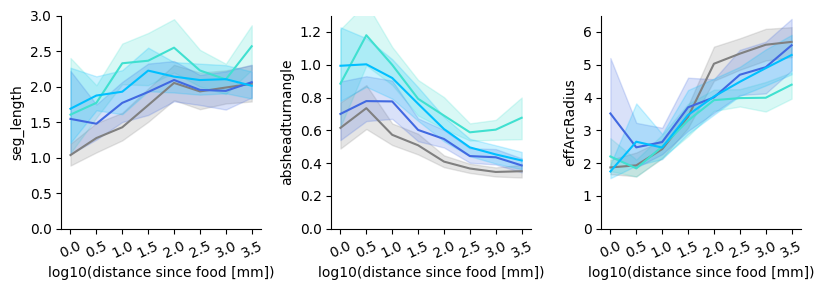

In [40]:
if postfix == 'afterfood':  #only makes sense after food
    pltdf = per_move_postfood_df_filt.groupby(['genotype','condition','cond-gen','flyid','dist_since_visit_log10_bin'],observed=False)[['seg_length','effArcRadius','absheadturnangle']].median().reset_index()
    
    qoi = ['seg_length','absheadturnangle','effArcRadius']
    ylims = [(0,3),(0,1.3),(0,6.5)]# #[(0,2.5),(0,1),(0,6.5)]# [(0.4,3),(0.2,1.5),(0,6.5)]#[(0.4,2.5),(0,6.5),(0.1,1.1)]

    fig, axs = plt.subplots(1,len(qoi),figsize=(2.75*len(qoi),3))

    for i, q in enumerate(qoi):
        ax = sns.lineplot(data = pltdf, x='dist_since_visit_log10_bin', y=q, hue='genotype', palette=pal, ax=axs[i])
        ax.set_xticks(np.arange(len(timebins)-1));
        ax.set_xticklabels(timebins[1:],rotation = 25);
        #if i!=2: 
        ax.legend('', frameon=False)
        myAxisTheme(ax)
        ax.set_ylim(ylims[i])
        ax.set_xlabel('log10(distance since food [mm])')
    fig.tight_layout()
    fig.savefig(plotDir+sep+'distsincefood_locomotion_Fig5H-J.pdf')

<a id='fig-s5c'></a>
## Fig. S5C, S5D, S5E - Bimodal distributions of log-transformed, normalized trip lengths for (S5C) SS96>Kir, (S5D) SS96>TNT, and (S5E) SS90>Kir

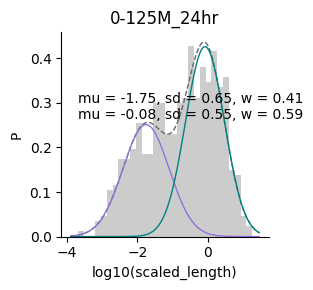

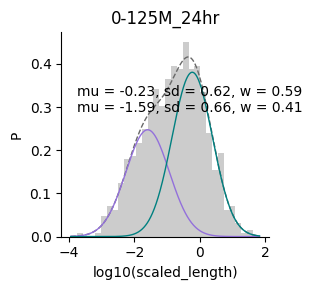

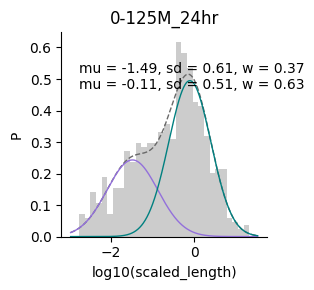

In [41]:
qOI = qOIs[qSlct]
fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "SS96xCS-Kir"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(plotDir+sep+'P_scaled_length_fitGMM_FigS5C.pdf')

fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "SS96xCSMH-TNT"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(plotDir+sep+'P_scaled_length_fitGMM_FigS5D.pdf')

fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "SS90_x_Kir"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(plotDir+sep+'P_scaled_length_fitGMM_FigS5E.pdf')

<a id='fig-s5f'></a>
## Fig. S5F - Probability of long trips as a function of trip index

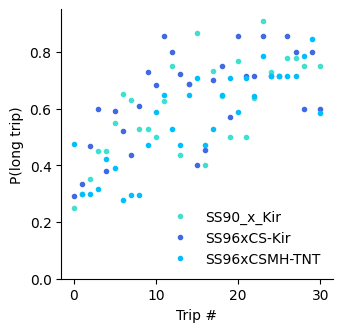

In [45]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
conds2plot = conditions[0:3]
plot_df2 = per_trip_df.query(f'condition in {conds2plot}').reset_index(drop=True)
for g, genotype in enumerate(genotypes[1:]):
    tmp = plot_df2.query(f'trip_index <=30 & genotype == "{genotype}" & condition == "{condOI}"')[['trip_index','triptype','length']].groupby(['triptype','trip_index']).count().unstack()
    pLongTrip = (tmp.query('triptype == "long"').values/(tmp.query('triptype == "long"').values+tmp.query('triptype == "short"').values))[0]
    ax.plot(np.arange(0,len(pLongTrip)),pLongTrip,'.', color=pal[genotype], label=genotype)
    ax.set_xlabel('Trip #')
    ax.set_ylabel('P(long trip)')
    ax.set_ylim(0,.95)
    ax.legend(frameon=False)
    myAxisTheme(ax)
fig.savefig(plotDir+os.sep+f'probabilityOfLongTrips_trvar-{qOIs[qSlct]}_FigS5F.pdf')

<a id='fig-s5g'></a>
## Fig. S5G - Run length distribution

beforefood
          a       loc     scale       genotype    condition    food
0 -2.628717  0.977031  0.746541      CantonSMH  0-125M_24hr  before
1 -2.079333  0.974614  0.659213     SS90_x_Kir  0-125M_24hr  before
2 -1.869065  0.874184  0.707366    SS96xCS-Kir  0-125M_24hr  before
3 -2.014123  1.086336  0.759887  SS96xCSMH-TNT  0-125M_24hr  before
afterfood
          a       loc     scale       genotype    condition   food
0 -2.718279  1.014646  0.751341      CantonSMH  0-125M_24hr  after
1 -2.487908  0.982140  0.735930     SS90_x_Kir  0-125M_24hr  after
2 -1.719208  0.886045  0.674371    SS96xCS-Kir  0-125M_24hr  after
3 -1.875467  1.091862  0.749998  SS96xCSMH-TNT  0-125M_24hr  after


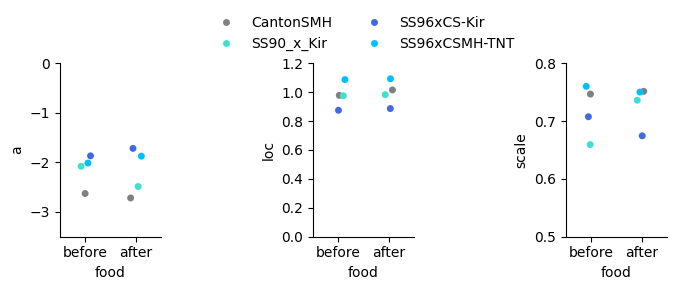

In [47]:
# extract data of interest
etho_state = [2] # 2: runs
qOI = 'seg_length'
iflogq = True
distOI = 'skewnorm'
criteria = {}

dffitRunLenAll = pd.DataFrame()
for visitTH in ['==0','>=1']: #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'
    
    fittedparamsall = np.nan*np.ones((3,len(genotypes)))
    for c, genotype in enumerate(genotypes):
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state}& genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'
        perMoveSegDF_filt = perMoveSegDF.query(querystring)
        if len(perMoveSegDF_filt) == 0: continue
        datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
        fittedparamsall[:,c] = fittedparams
    dffitRunLen = pd.DataFrame(data=fittedparamsall.T, columns = ['a','loc','scale'])
    dffitRunLen['genotype'] = genotypes
    dffitRunLen['condition'] = conditions[0]
    dffitRunLen['food'] = postfix[:-4]
    dffitRunLen = dffitRunLen.reset_index(drop=True).dropna()
    #dffitRunLen.to_csv(plotDir+sep+'runLengthDistribution_'+postfix+'.csv', index=False)  

    dffitRunLenAll = pd.concat([dffitRunLenAll,dffitRunLen])
    print(postfix)
    print(dffitRunLen)

fig, axs = plt.subplots(1,3, figsize=(7,3))

vlims = [[-3.5,0],[0,1.2],[.5,.8]]
for p, param in enumerate(['a','loc','scale']):
    sns.stripplot(data=dffitRunLenAll, x='food', y=param, hue='genotype', palette=pal, ax=axs[p], jitter=0.15)
    sns.despine()
    if p!=1: axs[p].legend([],[], frameon=False)
    else: sns.move_legend(axs[p], "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
    axs[p].set_ylim(vlims[p])
fig.tight_layout()
fig.savefig(plotDir+sep+'runLengthDistributionFitParams_'+postfix+'_FigS5G.pdf')

<a id='fig-s5h'></a>
## Fig. S5H - Turn angle distribution

/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


beforefood
          s       loc     scale    condition       genotype    food
0  0.776713 -0.042273  0.333216  0-125M_24hr      CantonSMH  before
1  0.840989 -0.057920  0.521163  0-125M_24hr     SS90_x_Kir  before
2  0.886303 -0.034833  0.362149  0-125M_24hr    SS96xCS-Kir  before
3  0.859522 -0.038570  0.392471  0-125M_24hr  SS96xCSMH-TNT  before
afterfood
          s       loc     scale    condition       genotype   food
0  0.791744 -0.047435  0.416081  0-125M_24hr      CantonSMH  after
1  0.787089 -0.094137  0.692562  0-125M_24hr     SS90_x_Kir  after
2  0.837769 -0.049507  0.458304  0-125M_24hr    SS96xCS-Kir  after
3  0.898077 -0.057164  0.524235  0-125M_24hr  SS96xCSMH-TNT  after


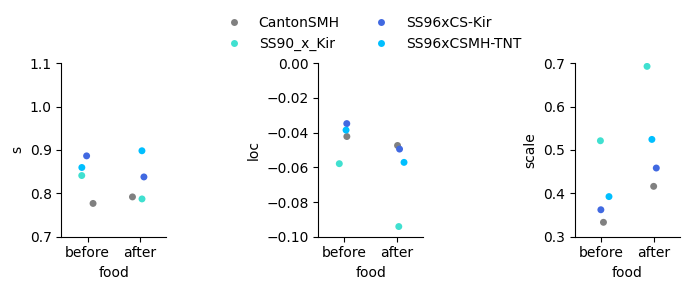

In [48]:
# extract data of interest
etho_state = [1] # 1: turns
qOI = 'absheadturnangle'
iflogq = False
distOI = 'lognorm'
xlims = (0,3.5) #0,3

dffitTurnAngAll = pd.DataFrame()
for visitTH in ['==0','>=1']: #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'
    
    fittedparamsall = np.nan*np.ones((3,len(genotypes)))
    for c, genotype in enumerate(genotypes):
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} &  genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'
        perMoveSegDF_filt = perMoveSegDF.query(querystring)
        if len(perMoveSegDF_filt) == 0: continue
        datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
        fittedparamsall[:,c] = fittedparams
    dffitTurnAng = pd.DataFrame(data=fittedparamsall.T, columns = ['s','loc','scale'])
    dffitTurnAng['condition'] = conditions[0]
    dffitTurnAng['genotype'] = genotypes
    dffitTurnAng['food'] = postfix[:-4]
    dffitTurnAng = dffitTurnAng.reset_index(drop=True).dropna()
    #dffitTurnAng.to_csv(plotDir+sep+'turnAngleDistribution_'+postfix+'.csv', index=False)  
    dffitTurnAngAll = pd.concat([dffitTurnAngAll,dffitTurnAng])
    print(postfix)
    print(dffitTurnAng)

fig, axs = plt.subplots(1,3, figsize=(7,3))

vlims = [[.7,1.1],[-.1,0],[.3,.7]]
for p, param in enumerate(['s','loc','scale']):
    sns.stripplot(data=dffitTurnAngAll, x='food', y=param, hue='genotype', palette=pal, ax=axs[p], jitter=0.15)
    sns.despine()
    if p!=1: axs[p].legend([],[], frameon=False)
    else: sns.move_legend(axs[p], "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
    axs[p].set_ylim(vlims[p])
fig.tight_layout()
fig.savefig(plotDir+sep+'turnAngleDistributionFitParams_'+postfix+'_FigS5H.pdf')

<a id='fig-s5i'></a>
## Fig. S5I - Turn radius distribution

beforefood
          c       loc     scale    condition       genotype    food
0  1.235383  0.636002  0.253138  0-125M_24hr      CantonSMH  before
1  1.367190  0.612634  0.211503  0-125M_24hr     SS90_x_Kir  before
2  2.075991  0.386709  0.289517  0-125M_24hr    SS96xCS-Kir  before
3  2.100439  0.395333  0.281432  0-125M_24hr  SS96xCSMH-TNT  before
afterfood
          c       loc     scale    condition       genotype   food
0  1.027670  0.683568  0.227337  0-125M_24hr      CantonSMH  after
1  1.226052  0.515815  0.197182  0-125M_24hr     SS90_x_Kir  after
2  1.755003  0.446173  0.263341  0-125M_24hr    SS96xCS-Kir  after
3  2.389032  0.324088  0.272139  0-125M_24hr  SS96xCSMH-TNT  after


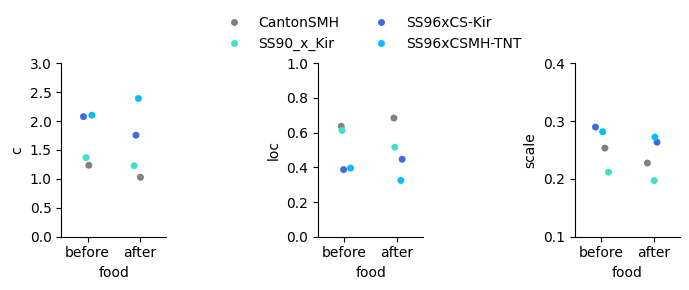

In [49]:
# extract data of interest
etho_state = [1] # 1: turns
qOI = 'effArcRadius'
iflogq = True
distOI = 'genlogistic'
xlims = (-1.5, 2.5)

dffitTurnRadAll = pd.DataFrame()
for visitTH in ['==0','>=1']: #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'
    
    fittedparamsall = np.nan*np.ones((3,len(genotypes)))
    for c, genotype in enumerate(genotypes):
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'
        perMoveSegDF_filt = perMoveSegDF.query(querystring)
        if len(perMoveSegDF_filt) == 0: continue
        datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
        fittedparamsall[:,c] = fittedparams
    dffitTurnRad = pd.DataFrame(data=fittedparamsall.T, columns = ['c','loc','scale'])
    dffitTurnRad['condition'] = conditions[0]
    dffitTurnRad['genotype'] = genotypes
    dffitTurnRad['food'] = postfix[:-4]
    dffitTurnRad = dffitTurnRad.reset_index(drop=True).dropna()
    
    #dffitTurnRad.to_csv(plotDir+sep+'turnRadiusDistribution_'+postfix+'.csv', index=False)  
    dffitTurnRadAll = pd.concat([dffitTurnRadAll,dffitTurnRad])
    print(postfix)
    print(dffitTurnRad)

fig, axs = plt.subplots(1,3, figsize=(7,3))

vlims = [[0,3],[0,1],[.1,.4]]
for p, param in enumerate(['c','loc','scale']):
    sns.stripplot(data=dffitTurnRadAll, x='food', y=param, hue='genotype', palette=pal, ax=axs[p], jitter=0.15)
    sns.despine()
    if p!=1: axs[p].legend([],[], frameon=False)
    else: sns.move_legend(axs[p], "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
    axs[p].set_ylim(vlims[p])
fig.tight_layout()
fig.savefig(plotDir+sep+'turnRadiusDistributionFitParams_'+postfix+'_FigS5I.pdf')

<a id='fig-s5j'></a>
## Fig. S5J - Absolute turn size distribution across genotypes before (left) and after (right) food

/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


,s,loc,scale,condition,genotype
0,0.791744,-0.047435,0.416081,0-125M_24hr,CantonSMH
1,0.791744,-0.047435,0.416081,0-125M_24hr,SS90_x_Kir
2,0.787089,-0.094137,0.692562,0-125M_24hr,SS90_x_Kir
3,0.791744,-0.047435,0.416081,0-125M_24hr,SS96xCS-Kir
4,0.787089,-0.094137,0.692562,0-125M_24hr,SS96xCS-Kir
5,0.837769,-0.049507,0.458304,0-125M_24hr,SS96xCS-Kir
6,0.791744,-0.047435,0.416081,0-125M_24hr,SS96xCSMH-TNT
7,0.787089,-0.094137,0.692562,0-125M_24hr,SS96xCSMH-TNT
8,0.837769,-0.049507,0.458304,0-125M_24hr,SS96xCSMH-TNT
9,0.898077,-0.057164,0.524235,0-125M_24hr,SS96xCSMH-TNT


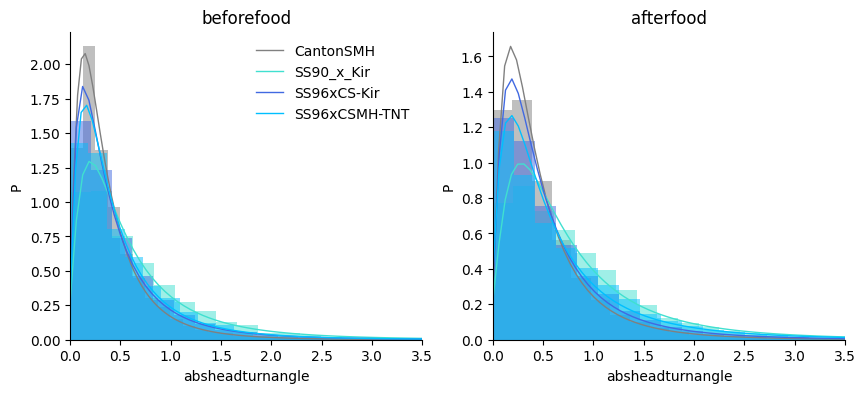

In [51]:
# extract data of interest
etho_state = [1] # 1: turns
qOI = 'absheadturnangle'
iflogq = False
distOI = 'lognorm'
xlims = (0,3.5)
numbins=30

fig, axs = plt.subplots(1,2,figsize=(10,4))

for i, visitTH in enumerate(['==0','>=1']): #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    ax = axs[i]
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'

    dffitTurnAngAll = pd.DataFrame()
    fittedparamsall = np.nan*np.ones((3,len(genotypes)))
    for g, genotype in enumerate(genotypes):
        plotcol = pal[genotype]
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'

        perMoveSegDF_filt = perMoveSegDF.query(querystring)
        if len(perMoveSegDF_filt) == 0: continue
        datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
        fittedparamsall[:,g] = fittedparams
        ax = plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol=plotcol,iflog = iflogq)
    
        dffitTurnAng = pd.DataFrame(data=fittedparamsall.T, columns = ['s','loc','scale'])
        dffitTurnAng['condition'] = conditions[0]
        dffitTurnAng['genotype'] = genotype
        dffitTurnAngAll = pd.concat([dffitTurnAngAll,dffitTurnAng])
        dffitTurnAngAll = dffitTurnAngAll.reset_index(drop=True).dropna()
        dffitTurnAngAll.to_csv(plotDir+sep+'turnAngleDistribution_'+postfix+'.csv', index=False)  
    
    ax.set_xlim(xlims)
    myAxisTheme(ax)
    ax.set_title(postfix)
axs[0].legend(genotypes, frameon=False)
fig.savefig(plotDir+sep+'turnAngleDistribution_'+postfix+'_FigS5J.pdf')
dffitTurnAngAll